**Installing PySpark**

In [11]:
!pip install pyspark

**Importing Essential Libraries for Spark Machine Learning Algorithms & Python Libraries**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

**Creating a Spark Session and Loading Dataset**

In [13]:
# Create a Spark session
spark = SparkSession.builder.appName("Diabetes Prediction").getOrCreate()

# Load the dataset
df = spark.read.csv('/content/drive/MyDrive/DineshThapa/diabetes.csv', header=True, inferSchema=True)
df.show()

+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|              0|     1|       1|        1| 40|     1|     0|                   0|           0|     0|      1|                0|            1|          0|      5|      18|      15|       1|  0|  9|        4|     3|
|              0|     0|       0|        0| 25|     1|     0|                   0|           1|     0|      0|                0|            

**Counting the number of diabetic and non-diabetic samples**

In [14]:
# Count the number of diabetic and non-diabetic samples
diabetic_count = df.filter(df['Diabetes_binary'] == 1).count()
non_diabetic_count = df.filter(df['Diabetes_binary'] == 0).count()

# Print the results
print("Diabetic Samples: " + str(diabetic_count))
print("Non-Diabetic Samples: " + str(non_diabetic_count))

Diabetic Samples: 35346
Non-Diabetic Samples: 218334


**Dealing with Imbalanced Data**

In [16]:
# Filter and select 35,346 diabetic samples
diabetic_data = df.filter(df['Diabetes_binary'] == 1).limit(35346)

# Filter and select 35,346 non-diabetic samples
non_diabetic_data = df.filter(df['Diabetes_binary'] == 0).limit(35346)

# Concatenate the two DataFrames
df = diabetic_data.union(non_diabetic_data)

**Remove Duplicates and Outliers**

In [17]:
from pyspark.sql.functions import expr
from pyspark.sql.functions import when

# First, calculate the median of BMI where BMI is less than or equal to 50
median_bmi = df.filter(df['BMI'] <= 50).approxQuantile('BMI', [0.5], 0.0)[0]

# Update BMI values greater than 50 to the median BMI
df = df.withColumn('BMI', when(df['BMI'] > 50, median_bmi).otherwise(df['BMI']))


**Show the shape of the DataFrame and count the values in the Diabetes dataset**

In [ ]:
# Show the shape of the DataFrame and count the values in the Diabetes dataset
print((df.count(), len(df.columns)))
df.groupby('Diabetes_binary').count().show()
df.printSchema()

**Finding Null Values**

In [ ]:
# Data cleaning: Finding NULL values in each column
def dataCleaning(df):
    for col in df.columns:
        print(col, ":", df.filter(df[col].isNull()).count())

print("Finding NULL values:")
dataCleaning(df)

**Removing Null Values**

In [ ]:
# Removing rows where any column data is missing
#df = df.na.drop()

# Checking again for NULL values to confirm cleaning
#print("After Cleaning, NULL values:")
#dataCleaning(df)

# Data transformation: Replace categorical data with numerical data and drop unused columns
df = df.drop('CholCheck')  # Drop this if it's not used or irrelevant

**Data Encoding and Encoding Categorical variables**

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Encoding categorical columns and assembling a feature vector
categoricalColumns = ['Income','Education']
stages = []  # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    indexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Using OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [indexer, encoder]

**Feature Selection**

In [20]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="Diabetes_binary", outputCol="label")
stages += [label_stringIdx]

# Transform all features into a vector using VectorAssembler
numericCols = ['HighBP', 'DiffWalk', 'GenHlth', 'BMI', 'HighChol', 'PhysHlth', 'HeartDiseaseorAttack', 'Age', 'PhysActivity', 'Stroke']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

**Feature Scaling**

In [21]:
#feature_scaling
from pyspark.ml.feature import StandardScaler

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
stages += [scaler]

In [22]:
# Create a Pipeline that chains together the transformations
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)

In [23]:
# Show transformed DataFrame to verify
df_transformed.show()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+-----------+--------------+--------------+-----------------+-----+--------------------+--------------------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|IncomeIndex|IncomeclassVec|EducationIndex|EducationclassVec|label|            features|      scaledFeatures|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+-----------+--------------+--------------+-----------------+-----+--------------------+--------------------+
|              1|     1|    

**Splitting the Data into training, test and validation**

In [24]:
# Split the data into training, test, and validation sets
train_data, test_data, val_data = df_transformed.randomSplit([0.6, 0.2, 0.2], seed=42)

**Logistic Regression Model Training, Testing, Validation and Evaluation**

In [29]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression Model
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10)
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)
val_predictions = lr_model.transform(val_data)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
val_auc = evaluator.evaluate(val_predictions)

print("Logistic Regression Test AUC: ", lr_auc)
# Confusion Matrix
print("Confusion Matrix on Test Set:")
lr_predictions.groupBy('label', 'prediction').count().show()

print(f"Logistic Regression Validation AUC: {val_auc}")
# Confusion Matrix
print("Confusion Matrix on Validation Set:")
val_predictions.groupBy('label', 'prediction').count().show()

Logistic Regression Test AUC:  0.8289606472100819
Logistic Regression Validation AUC: 0.8323600647693522
Confusion Matrix on Test Set:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5323|
|  1.0|       0.0| 1603|
|  0.0|       1.0| 1880|
|  0.0|       0.0| 5260|
+-----+----------+-----+

Confusion Matrix on Validation Set:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5566|
|  1.0|       0.0| 1495|
|  0.0|       1.0| 1904|
|  0.0|       0.0| 5064|
+-----+----------+-----+



**Logistic Regression Model: Accuracy Measures by Precision, Recall, F1 Score and Support**

In [26]:
from pyspark.sql.functions import expr

# Calculate precision, recall, f1-score, and support for class '1' (having diabetes)
tp = lr_predictions.filter("label = 1 and prediction = 1").count()
fp = lr_predictions.filter("label = 0 and prediction = 1").count()
fn = lr_predictions.filter("label = 1 and prediction = 0").count()

precision_1 = tp / (tp + fp)
recall_1 = tp / (tp + fn)
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
support_1 = tp + fn

print("Precision for class '1' (having diabetes): ", precision_1)
print("Recall for class '1' (having diabetes): ", recall_1)
print("F1-score for class '1' (having diabetes): ", f1_1)
print("Support for class '1' (having diabetes): ", support_1)

# Calculate precision, recall, f1-score, and support for class '0' (not having diabetes)
tn = lr_predictions.filter("label = 0 and prediction = 0").count()
fn = lr_predictions.filter("label = 1 and prediction = 0").count()

precision_0 = tn / (tn + fn)
recall_0 = tn / (tn + fp)
f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
support_0 = tn + fp

print("Precision for class '0' (not having diabetes): ", precision_0)
print("Recall for class '0' (not having diabetes): ", recall_0)
print("F1-score for class '0' (not having diabetes): ", f1_0)
print("Support for class '0' (not having diabetes): ", support_0)


Precision for class '1' (having diabetes):  0.7389976398722754
Recall for class '1' (having diabetes):  0.7685532775050534
F1-score for class '1' (having diabetes):  0.7534857385519144
Support for class '1' (having diabetes):  6926
Precision for class '0' (not having diabetes):  0.7664286755063383
Recall for class '0' (not having diabetes):  0.7366946778711485
F1-score for class '0' (not having diabetes):  0.7512675855173891
Support for class '0' (not having diabetes):  7140


**Random Forest Classifier: Training and Testing**

In [30]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest Model
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=10)
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
rf_auc = evaluator.evaluate(rf_predictions)
print("Random Forest AUC: ", rf_auc)

# Confusion Matrix
rf_predictions.groupBy('label', 'prediction').count().show()

Random Forest AUC:  0.8202784073490791
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5458|
|  1.0|       0.0| 1468|
|  0.0|       1.0| 2092|
|  0.0|       0.0| 5048|
+-----+----------+-----+



**Gradient-Boosted Trees Classifier: Training and Testing**

In [31]:
from pyspark.ml.classification import GBTClassifier

# Gradient-Boosted Trees Model
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
gbt_auc = evaluator.evaluate(gbt_predictions)
print("Gradient-Boosted Trees AUC: ", gbt_auc)

# Confusion Matrix
gbt_predictions.groupBy('label', 'prediction').count().show()


Gradient-Boosted Trees AUC:  0.8267305593909525
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5455|
|  1.0|       0.0| 1471|
|  0.0|       1.0| 2042|
|  0.0|       0.0| 5098|
+-----+----------+-----+



**Visualizing the Confusion Matrix**

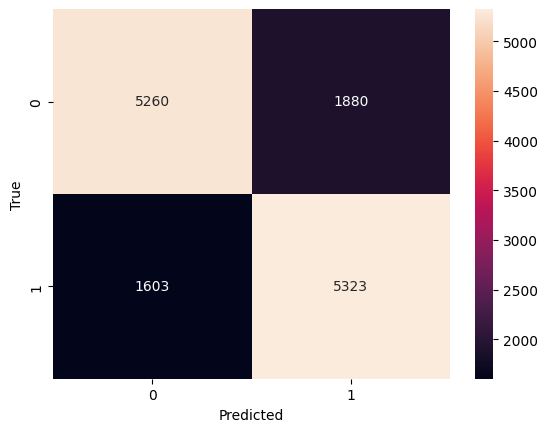

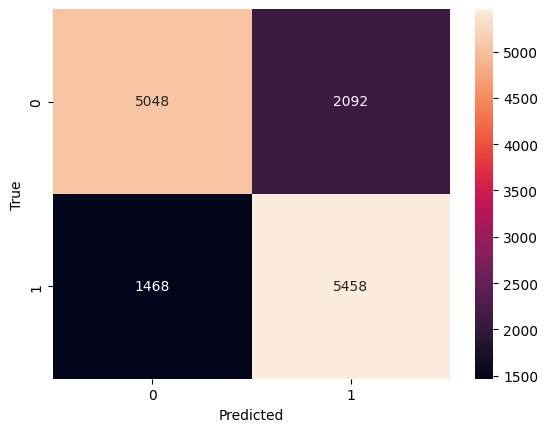

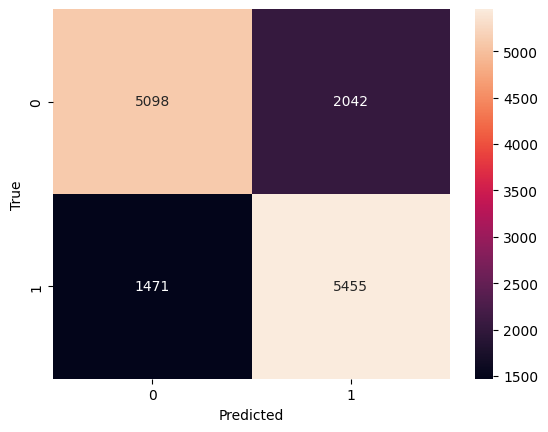

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(predictions):
    y_true = predictions.select("label").collect()
    y_pred = predictions.select("prediction").collect()

    cm = confusion_matrix([int(row.label) for row in y_true], [int(row.prediction) for row in y_pred])
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot for Logistic Regression
plot_confusion_matrix(lr_predictions)

# Plot for Random Forest
plot_confusion_matrix(rf_predictions)

# Plot for Gradient-Boosted Trees
plot_confusion_matrix(gbt_predictions)

**Model Runtime Evaluation**

In [33]:
import time

# Logistic Regression Runtime
start_time_lr = time.time()
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
end_time_lr = time.time()
print("Logistic Regression training and prediction time: {:.2f} seconds".format(end_time_lr - start_time_lr))

# Random Forest Runtime
start_time_rf = time.time()
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
end_time_rf = time.time()
print("Random Forest training and prediction time: {:.2f} seconds".format(end_time_rf - start_time_rf))

# Gradient-Boosted Trees Runtime
start_time_gbt = time.time()
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
end_time_gbt = time.time()
print("Gradient-Boosted Trees training and prediction time: {:.2f} seconds".format(end_time_gbt - start_time_gbt))

Logistic Regression training and prediction time: 34.01 seconds
Random Forest training and prediction time: 25.56 seconds
Gradient-Boosted Trees training and prediction time: 25.72 seconds


**Model Scalability Evaluation**

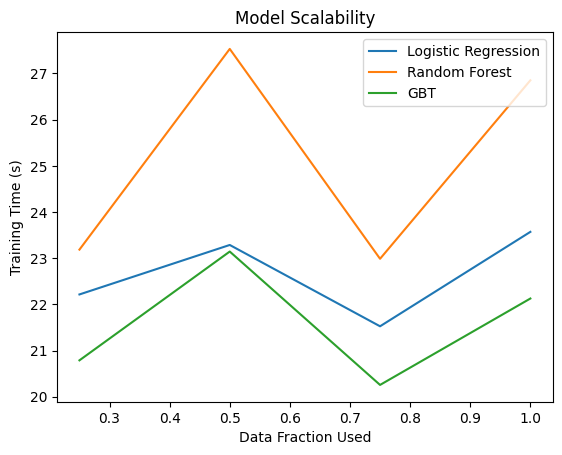

In [34]:
def test_scalability(model, train_data, splits=[0.25, 0.5, 0.75, 1.0]):
    times = []
    for split in splits:
        current_train_data, _ = train_data.randomSplit([split, 1 - split], seed=42)
        start_time = time.time()
        model.fit(current_train_data)
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Test scalability for each model
splits = [0.25, 0.5, 0.75, 1.0]
lr_times = test_scalability(lr, train_data, splits)
rf_times = test_scalability(rf, train_data, splits)
gbt_times = test_scalability(gbt, train_data, splits)

# Plot scalability results
plt.plot(splits, lr_times, label='Logistic Regression')
plt.plot(splits, rf_times, label='Random Forest')
plt.plot(splits, gbt_times, label='GBT')
plt.xlabel('Data Fraction Used')
plt.ylabel('Training Time (s)')
plt.title('Model Scalability')
plt.legend()
plt.show()

**Precision-Recall Curve**

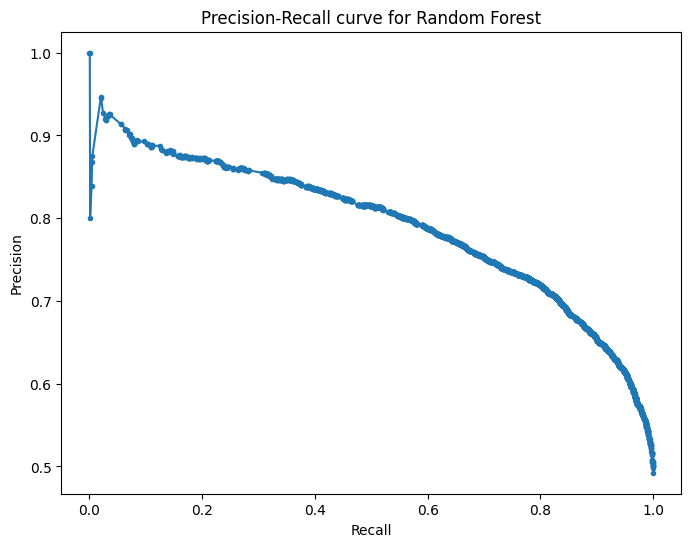

In [35]:
# Precision-Recall requires manual calculation or use of sklearn after collecting predictions
# Collect predictions and true labels
y_true = [row['label'] for row in rf_predictions.select("label").collect()]
y_scores = [row['probability'][1] for row in rf_predictions.select("probability").collect()]

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve for Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
